## Imports

In [1]:
## Uncomment only on colab
# !pip install transformers
# !git clone https://github.com/DanielSc4/Approach-LWD.git
# %cd Approach-LWD/src

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# from torch.utils.data import Dataset
from models.CustomDatasetBinary import CustomDatasetBinary
from torch.utils.data import DataLoader

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### models_name = 'bert-base-uncased'

### BERT
# models_name = 'bert-base-uncased'
### RoBERTa
model_name = 'xlm-roberta-base'

In [4]:
# selecting device based on whats available
device = ''
if torch.cuda.is_available():
    print('Using GPU')
    device = 'cuda'
# Only on torch night for Apple M1 GPU
elif torch.backends.mps.is_available():
    print('Using MPS (Apple Silicon GPU)')
    device = 'mps'
else:
    print('Using CPU, :(')
    device = 'cpu'

Using MPS (Apple Silicon GPU)


## Datasets & loaders

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# starting w/ MD dataset
df = pd.read_csv('../data/MD_LoD.csv', index_col = 0)
df

# exclude labels == 2 (slightly agreement)
df = df[df['disagreement_lev'] != 2]
# shuffle dataser
df = df.sample(frac=1)


BATCH_SIZE = 20

train_set = CustomDatasetBinary(df[df['split'] == 'train'], tokenizer, label_col = 'disagreement_lev')
val_set = CustomDatasetBinary(df[df['split'] == 'dev'], tokenizer, label_col = 'disagreement_lev')
test_set = CustomDatasetBinary(df[df['split'] == 'test'], tokenizer, label_col = 'disagreement_lev')


# ############ only to overfit a batch (test to check model's correctness)
# fake_df = pd.concat(
#     [df[:BATCH_SIZE]] * 7   # concat the same batch multiple times
# )
# train_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# val_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# test_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# print(f'----------\n|-> Using fake_df: size {len(fake_df)}\n----------')
# ############ comment this section to train on the entire data available


print(f'len: \n\tTrain: {len(train_set)}\n\tVal: {len(val_set)}\n\tTest: {len(test_set)}')

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)

len: 
	Train: 4662
	Val: 787
	Test: 2148


## Model

In [6]:
from models.TransformerBinaryClassifier import TransformerBinaryClassifier

from transformers import AutoModel
transformer_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
tokenizer(
    ['hello my name is Daniel', 'hello my name is Roberta'],
    padding = 'max_length', 
    max_length = 20, 
    truncation = True,
    return_tensors = "pt",
)

{'input_ids': tensor([[    0, 33600,    31,   759,  9351,    83, 11555,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 33600,    31,   759,  9351,    83, 12452,    11,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [8]:
# input of the model: 
#   input_ids
#   attention_mask
model = TransformerBinaryClassifier(
    model = transformer_model,
    dropout_rate = .2,
)
inp, lbl = next(iter(train_loader))
out = model(
    inp['input_ids'],
    inp['attention_mask'],
)
print(out.shape)
out.reshape(len(out)).shape


torch.Size([20, 1])


torch.Size([20])

In [9]:
from models.utils import train_loop
import torch.nn as nn

from torch.optim import Adam
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

history = train_loop(
    epochs = 5, 
    model = model, 
    device = device, 
    train_loader = train_loader, 
    val_loader = val_loader, 
    optimizer = optimizer, 
    criterion = criterion,
    log_freq = len(train_loader) // 10, 
    name = 'test0',
)

-- Epoch 01 --
   01) [train,    23] 	loss: 0.717
   01) [train,    46] 	loss: 0.698
   01) [train,    69] 	loss: 0.685
   01) [train,    92] 	loss: 0.709
   01) [train,   115] 	loss: 0.696
   01) [train,   138] 	loss: 0.694
   01) [train,   161] 	loss: 0.688
   01) [train,   184] 	loss: 0.683
   01) [train,   207] 	loss: 0.688
   01) [train,   230] 	loss: 0.682
   01) [eval,    23] 	loss: 0.124
   [Recap 01 epoch] - train_loss: 0.695, train_acc: 0.5660 | eval_loss: 0.684, eval_acc: 0.5952 | elapsed time: 1086.5s	 <-- Best epoch so far, val	 <-- Best epoch so far, acc

-- Epoch 02 --
   02) [train,    23] 	loss: 0.658
   02) [train,    46] 	loss: 0.683
   02) [train,    69] 	loss: 0.678
   02) [train,    92] 	loss: 0.699
   02) [train,   115] 	loss: 0.690


### Plot

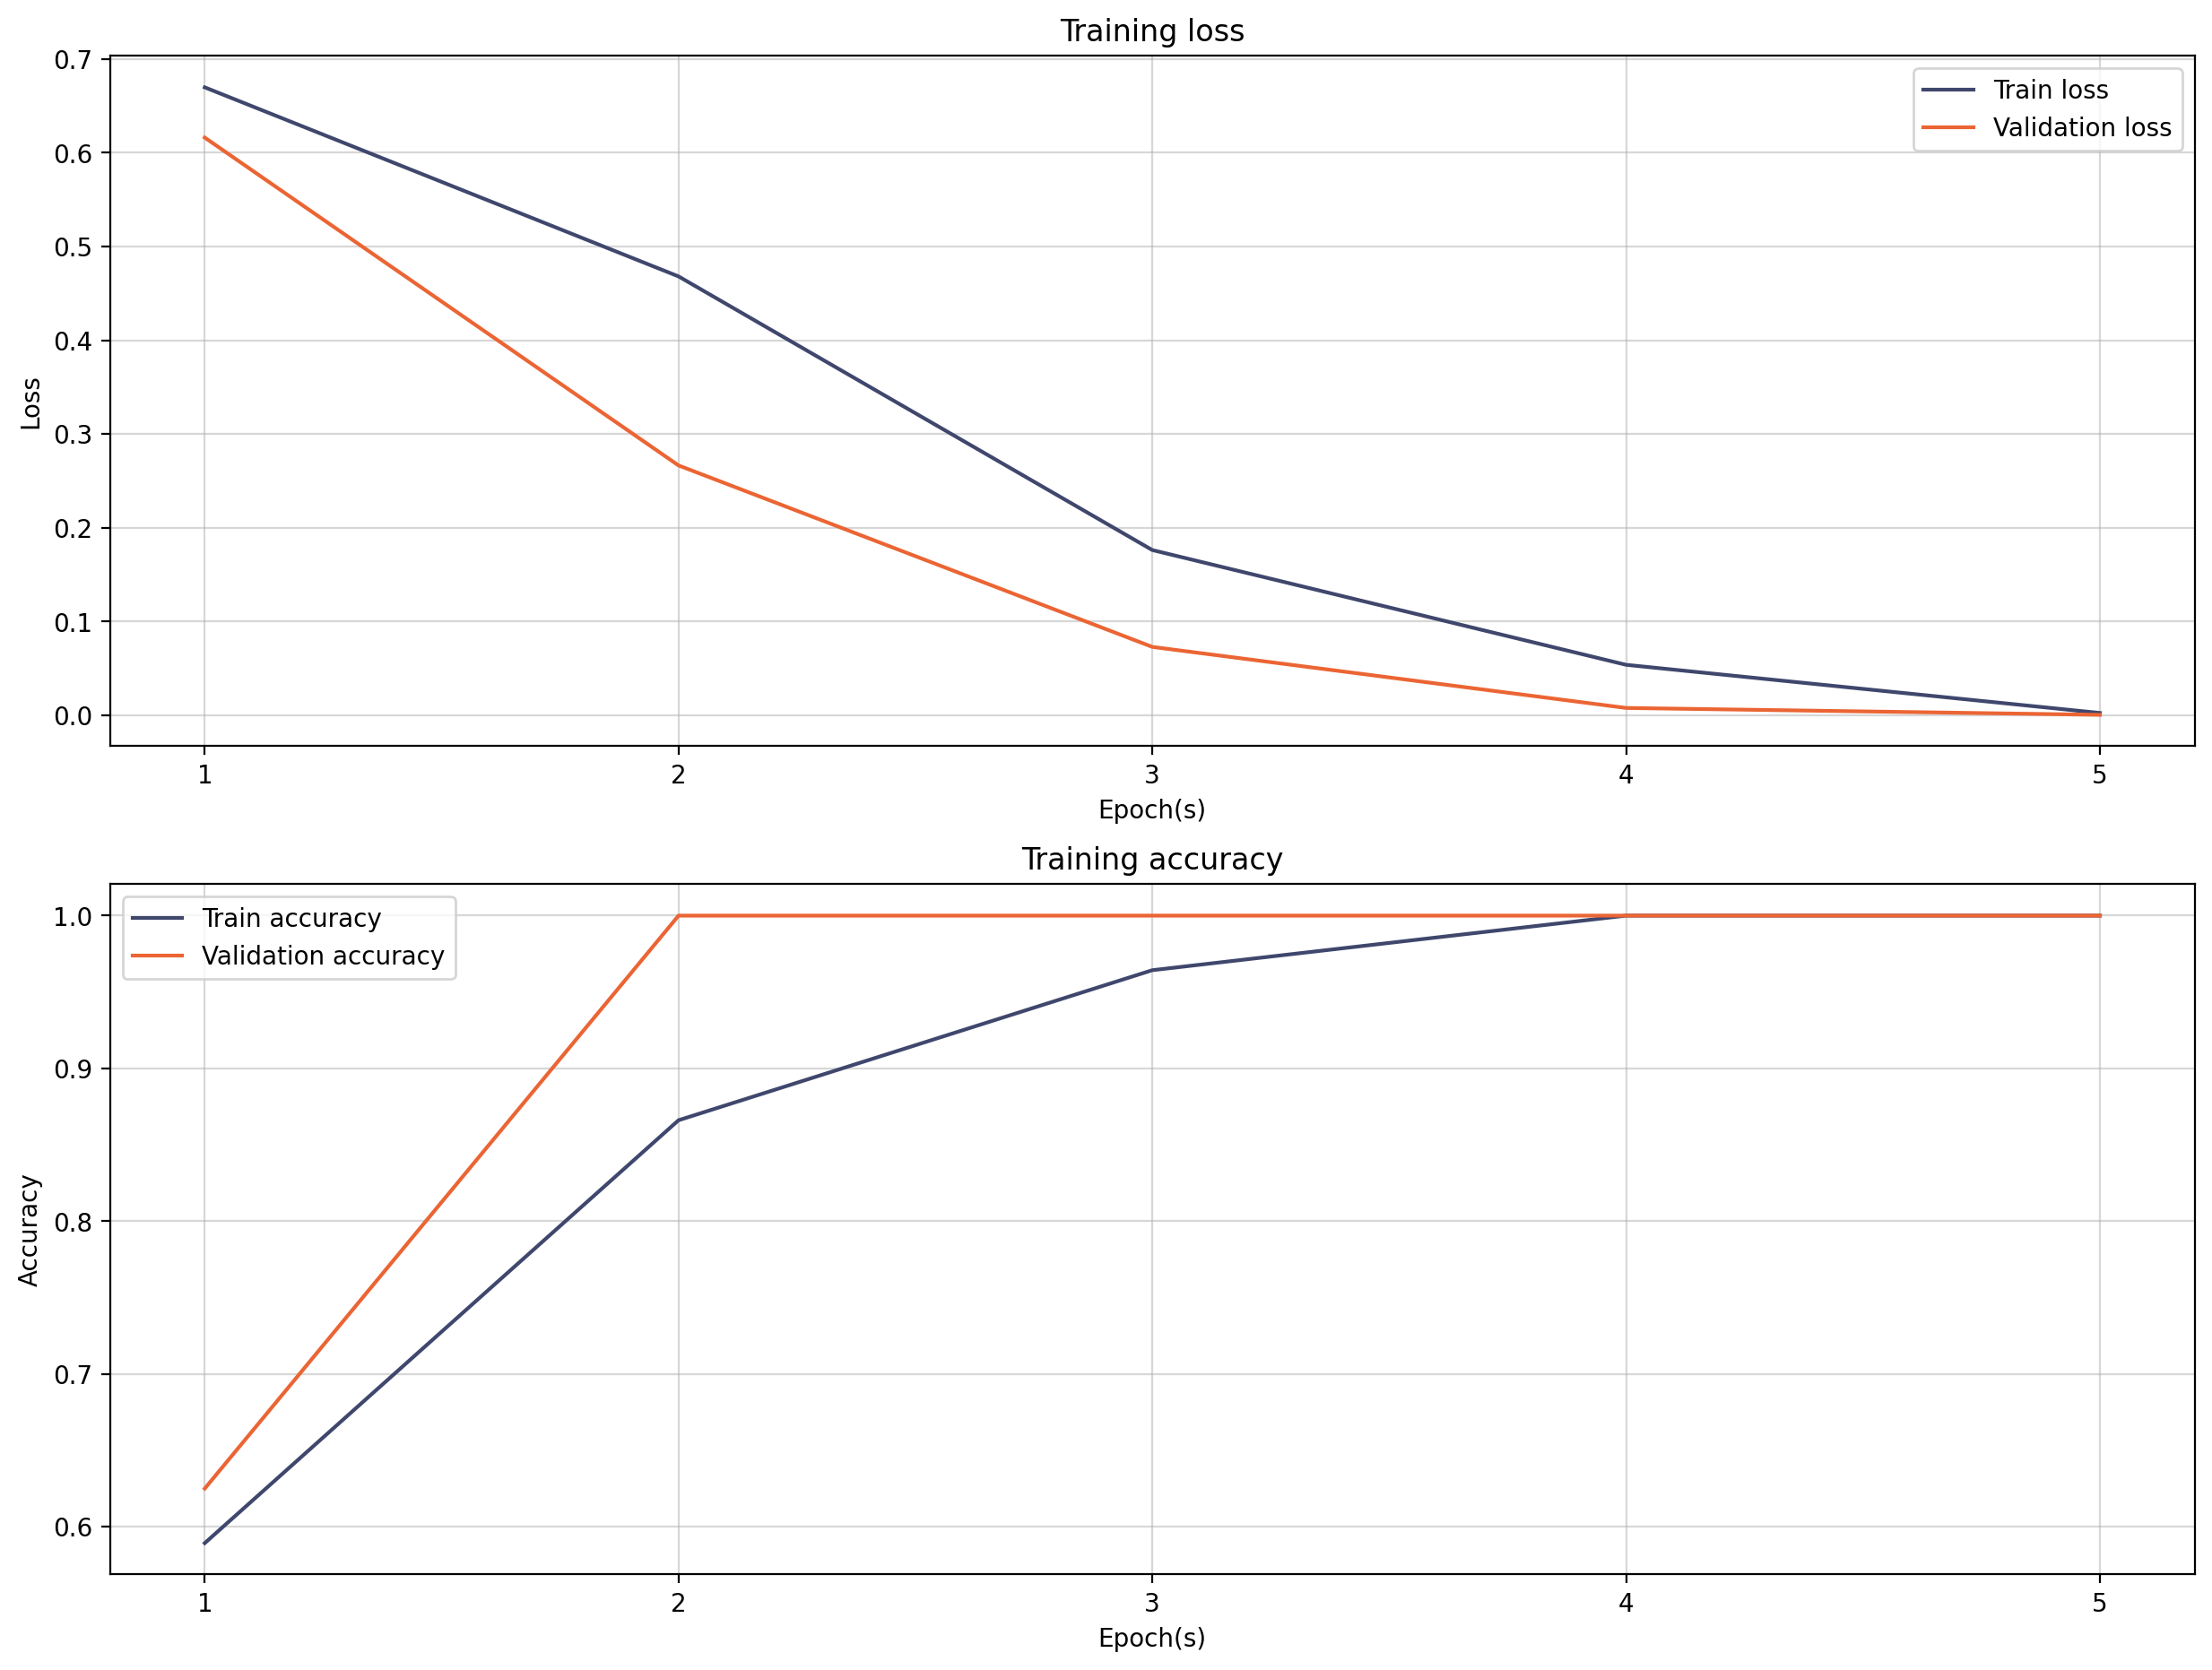

In [ ]:
palette = {
    0: '#ACBEA3', 
    1: '#40476D', 
    2: '#826754', 
    3: '#EB6534',
    4: '#AD5D4E'
}
plt.figure(figsize= (15, 11), dpi = 200)

plt.subplot(2, 1, 1)
x = np.arange(len(history['train_losses'])) + 1
plt.xticks(x)
plt.plot(x, history['train_losses'], label = 'Train loss', color = palette[1])
plt.plot(x, history['val_losses'], label = 'Validation loss', color = palette[3])
plt.title('Training loss')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.grid(alpha = .5)
plt.legend()

plt.subplot(2, 1, 2)
plt.xticks(x)
plt.plot(x, history['train_accs'], label = 'Train accuracy', color = palette[1])
plt.plot(x, history['val_accs'], label = 'Validation accuracy', color = palette[3])
plt.title('Training accuracy')
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.grid(alpha = .5)
plt.legend()

plt.show()

In [ ]:
# tmp store
import pickle
with open('backup_history.pkl', 'w') as f:
    pickle.dump(history, f)

## Test

In [31]:
from models.utils import compute_acc

test_model = history['final_model'].to(device)

test_model.eval()
test_accs = .0

for inputs, labels in test_loader:
    for ele in inputs:
            inputs[ele] = inputs[ele].to(device)
    labels = labels.to(device)
    with torch.no_grad():
          outputs = test_model(
                inputs['input_ids'],
                inputs['attention_mask'],
            ).reshape(len(labels))
    test_accs += compute_acc(outputs, labels)

print(f'Final accuracy: {test_accs / len(test_loader)}')

Final accuracy: 1.0
